# Missing Value Strategies
___`Understanding, Diagnosing, and Treating Missing Data`___
## Objective

This notebook provides a systematic and principled treatment of missing data, covering:

- Missingness mechanisms (MCAR, MAR, MNAR)

- Diagnostic techniques

- Statistical and ML-based imputation strategies

- When not to impute

- Leakage and bias risks

It answers:

    Why are values missing, and what is the least damaging way to handle them?

## Why Missing Values Matter

Incorrect handling of missing data can:

- Introduce bias

- Create data leakage

- Distort variance and correlations

- Break downstream models

Missingness is not a technical issue — it is a data-generation issue.

## Imports and Setup

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


# Loading Dataset
This notebook assumes one of the following datasets:

- synthetic_customer_value_regression_complete.csv

- synthetic_customer_churn_classification_complete.csv

For illustration, we load the __classification dataset.__ 

In [2]:
df = pd.read_csv("../datasets/synthetic_customer_churn_classification_complete.csv")
df.head()


,customer_id,age,income,tenure_years,avg_monthly_usage,support_tickets_last_year,satisfaction_level,customer_segment,region,churn,future_retention_offer
0,1,18,NaN,2.012501,138.021163,1,NaN,segment_18,South,0,-0.069047
1,2,18,58991.061162,9.005550,213.043003,2,Very High,segment_98,West,0,-0.226607
2,3,67,31130.298545,3.633058,68.591582,2,Medium,segment_134,North,0,-0.065741
3,4,64,NaN,4.295957,28.790894,1,NaN,segment_72,North,0,0.061886
4,5,37,22301.231175,2.549855,100.136569,2,High,segment_147,East,1,1.073678


# Step 1 – Missingness Overview
## Proportion of Missing Values

In [3]:
missing_rate = df.isna().mean().sort_values(ascending=False)
missing_rate


income                       0.30
satisfaction_level           0.25
avg_monthly_usage            0.04
age                          0.00
customer_id                  0.00
tenure_years                 0.00
support_tickets_last_year    0.00
customer_segment             0.00
region                       0.00
churn                        0.00
future_retention_offer       0.00
dtype: float64

## Missingness Heatmap

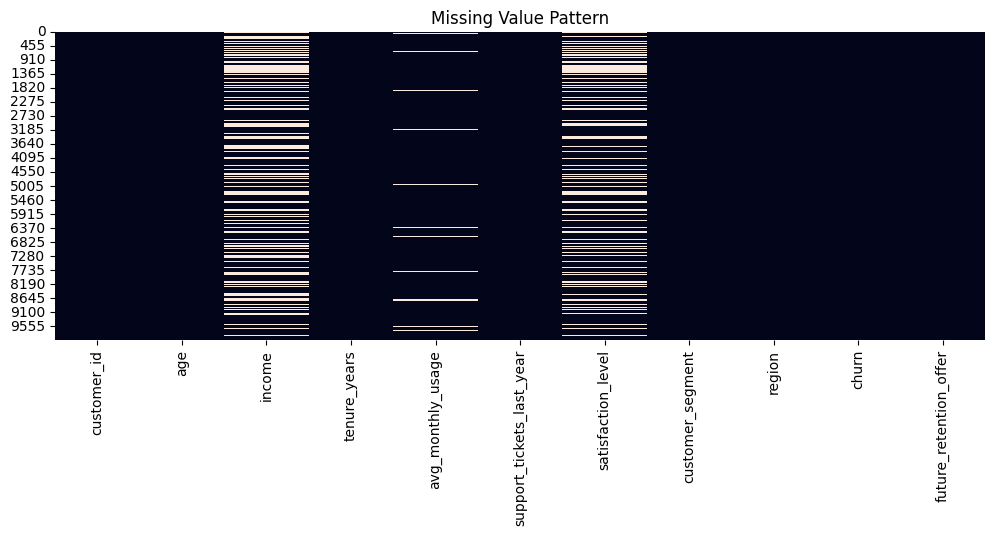

In [4]:
plt.figure(figsize=(12, 4))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Value Pattern")
plt.show()


Interpretation:

- Random scatter → likely MCAR

- Structured blocks → MAR / MNAR

# Step 2 – Missingness Mechanisms
## MCAR – Missing Completely at Random

Definition:

    Missingness independent of both observed and unobserved data.

Example symptom:

- Uniform random missing pattern

- No correlation with any variable

## MAR – Missing at Random

Definition:

    Missingness depends on observed variables.

Test example:

In [5]:
df.groupby(df["satisfaction_level"].isna())["tenure_years"].mean()


satisfaction_level
False    5.419308
True     5.511720
Name: tenure_years, dtype: float64

If values differ meaningfully → MAR likely.

## MNAR – Missing Not at Random

Definition:

    Missingness depends on the missing value itself or the target.

Example:

In [6]:
df.groupby(df["income"].isna())["churn"].mean()


income
False    0.181857
True     0.193000
Name: churn, dtype: float64

If churn differs → MNAR risk.

     MNAR cannot be fully corrected via imputation alone.

# Step 3 – Baseline Imputation Strategies
## Mean Imputation (Numeric)

__Problems:__

- Sensitive to outliers


- Underestimates variance

In [7]:
from sklearn.impute import SimpleImputer

mean_imputer = SimpleImputer(strategy="mean")

df_mean = df.copy()
df_mean["avg_monthly_usage"] = mean_imputer.fit_transform(
    df_mean[["avg_monthly_usage"]]
)




## Median Imputation (Preferred)

- Robust to skewness and outliers


- Default choice for numeric features

In [8]:
median_imputer = SimpleImputer(strategy="median")

df_median = df.copy()
df_median["avg_monthly_usage"] = median_imputer.fit_transform(
    df_median[["avg_monthly_usage"]]
)


## Mode Imputation (Categorical)

In [19]:
mode_imputer = SimpleImputer(strategy="most_frequent")

df_cat = df.copy()
df_cat[["satisfaction_level"]] = mode_imputer.fit_transform(
    df_cat[["satisfaction_level"]]
)


# Step 4 – Indicator Variables (Highly Recommended)

Missingness itself can be predictive.

In [23]:
df_indicator = df.copy()

df_indicator["income_missing"] = df_indicator["income"].isna().astype(int)


- Especially useful under MAR / MNAR
- Often improves tree-based models


# Step 5 – Advanced Imputation
## KNN Imputation

In [25]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=5)

numeric_cols = [
    "age",
    "income",
    "tenure_years",
    "avg_monthly_usage"
]

df_knn = df.copy()
df_knn[numeric_cols] = knn_imputer.fit_transform(df_knn[numeric_cols])


-  Preserves local structure
-  Computationally expensive
-  Sensitive to scaling


## Iterative / Model-Based Imputation

In [26]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

iter_imputer = IterativeImputer(
    random_state=42,
    max_iter=10
)

df_iter = df.copy()
df_iter[numeric_cols] = iter_imputer.fit_transform(df_iter[numeric_cols])


- [ok] - Best statistical properties
- [ok] - Suitable for MAR
- [NO] - Slower, more complex




# Step 6 – When NOT to Impute

Do not blindly impute when:

- Missingness is MNAR and business-critical

- Missing rate > 40–50%

- Feature is unreliable or proxy leakage

- Imputation distorts target relationships

Alternative:

- Drop feature

- Use missing indicator only

- Redesign data collection

# Step 7 – Leakage Risks

- [no] -  Fitting imputers on full dataset
- [no] -  Using target-aware imputations
- [no] -  Imputing after train/test split incorrectly

- [ok] -  Always fit imputers inside pipelines

# Step 8 – Pipeline-Safe Imputation Example

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])


This ensures:


- No leakage


- Reproducibility


- Deployment safety

# Summary



| Strategy          | When to Use           |
| ----------------- | --------------------- |
| Mean              | Rarely                |
| Median            | Default numeric       |
| Mode              | Categorical           |
| Missing indicator | MAR / MNAR            |
| KNN               | Small datasets        |
| Iterative         | High-quality modeling |
| Drop feature      | High MNAR risk        |


## Key Takeaways


- Missingness is signal, not noise


- Diagnose before treating


- Median > mean for numeric


- Indicators often outperform fancy imputers


- Pipelines are mandatory for safety